# Note to cover steps of an experiment to run supervised learning driven by a feature set generated from unsupervised model. 

### Data used originates from https://ai.stanford.edu/~amaas/data/sentiment/

ref: https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.bib

In [1]:
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import os

In [6]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.metrics import fbeta_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['retina']
import pyLDAvis.gensim
from datacode.retrieve_data import pull_data
from matplotlib import pyplot

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/topper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from sklearn.metrics import fbeta_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

## Set up various paths in readiness for writing or reading in data and model logs etc

In [8]:
root_dir = os.path.dirname(os.path.dirname(os.path.abspath("LICENSE")))
interim_data_path = os.path.join(root_dir, "data/interim")
processed_data_path = os.path.join(root_dir, "data/processed")
raw_data_path = os.path.join(root_dir, "data/raw")

corpus_path = os.path.join(interim_data_path, "train_corpus4.pkl")
id2word_path = os.path.join(interim_data_path, "train_id2word4.pkl")
bigram_train_path = os.path.join(interim_data_path, "bigram_train4.pkl")

model_log = os.path.join(processed_data_path, "logs/lda_model.log")
model_data = os.path.join(processed_data_path, "model_data/lda_train4.model")

X_data = os.path.join(interim_data_path, "X_train_feature_set.pkl")
y_data = os.path.join(interim_data_path, "y_train_set.pkl")

X_test_data = os.path.join(interim_data_path, "X_test_feature_set.pkl")
y_test_data = os.path.join(interim_data_path, "y_test_set.pkl")

## Import the IMDB data.
#### As per the above 'raw_data_path' variable, the model expects the data to be in the directory:  model_root_dir/data/raw/

In [9]:
imdb_train = load_files(os.path.join(raw_data_path, "aclImdb/train"))
text_train, y_train = imdb_train.data, imdb_train.target
text_train_df = pd.DataFrame({'text': text_train})

In [10]:
text_train_df.head()

,text
0,b'Full of (then) unknown actors TSF is a great...
1,"b""Amount of disappointment I am getting these ..."
2,"b'The future, we are told, are what we make of..."
3,"b""Dan Katzir has produced a wonderful film tha..."
4,b'If you want Scream or anything like the big-...


# Unsupervised learning phase

### Run pre-processing steps to remove stop words, tokenize and create bi-grams. 
#### Bigrams being terms which typically occur together such as 'sci fi' so the pre-process step will join them together. 

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Better to add to a YAML or other text file in due course
stop_words.extend(['film','films','movie','picture','review','watch','movies','see',
                    'xc','seems','think','would','could','get', 'however','people','many',
                    'us','jane','also','jones','know','even','great','good','bad','poor',
                   'terrible','awful','stink','brilliant','lame','stupid','loved','hate','hated',
                   'enjoy','enjoyed','garbage','really','best','wonderful','much','make','well','man',
                   'woman','much','actually','little','small','guess','never','always', 'joy',
                   'love','english','french','quite','beautiful','hit','joe','james','adam','crap',
                   'worst','best','jesus'])

In [12]:
def sent_to_words(sentences):
    """ Converts a document into a list of lowercase tokens, removing accent marks"""
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    """ Work through word list and drop items belonging to the stop list"""
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Detecting phrases based on collocation counts bi_min=15, tri_min=10
def bigrams(words, bi_min=1, tri_min=1):
    """ Grouping related phrases together into bigrams """
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [13]:
def get_corpus(df):
    """
    Call the pre-processing functions.
    Returns:
    corpus: A list object. A sparse vector of the integer representing the particular word and the number of time it
            appears in that document. (a document is one review)
    id2word: A gensip dictionary object holding a mapping of word IDs to words.  Determines the vocabulary size.
    bigram: A list of lists. With each (now processed) word in each IMDB review split out into individual terms.  
    """
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [15]:
# Create the key inputs for the lda model
train_corpus4, train_id2word4, bigram_train4 = get_corpus(text_train_df)  

In [29]:
# Keep the files
with open(corpus_path, 'wb') as f:
    pickle.dump(train_corpus4, f)
with open(id2word_path, 'wb') as f:
    pickle.dump(train_id2word4, f)
with open(bigram_train_path, 'wb') as f:
    pickle.dump(bigram_train4, f)

In [8]:
# Bring in previously stored files
with open(corpus_path, 'rb') as f:
    train_corpus4 = pickle.load(f)
with open(id2word_path, 'rb') as f:
    train_id2word4 = pickle.load(f)
with open(bigram_train_path, 'rb') as f:
    bigram_train4 = pickle.load(f)

## Create the LDA model

In [16]:
import logging

logging.basicConfig(filename=model_log, format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=4, # Num. Processing Cores - 1
                           passes=10,
                           #eval_every = 1,
                           per_word_topics=True)
    lda_train4.save(model_data)

In [21]:
# Retrieve model data from prior run
lda_train4 = gensim.models.ldamodel.LdaModel.load(model_data)

### Checking the list of terms in each Topic
#### Despite several runs, amending number of topics and the stop words I was unable to get a topic relevant to 'Acting' that was distinct from 'Story'.  So the original Hypothesis check was unobtainable.

In [17]:
# List topics and their terms
for topic in lda_train4.show_topics(num_topics=20, num_words=10, log=False, formatted=True):
    print([train_id2word4[id[0]] for id in lda_train4.get_topic_terms(topic[0])])

['show', 'way', 'character', 'characters', 'life', 'still', 'anyone', 'fine', 'completely', 'relationship']
['gets', 'time', 'father', 'something', 'getting', 'horror', 'guy', 'right', 'top', 'point']
['remake', 'life', 'made', 'gets', 'old', 'scene', 'save', 'shows', 'tv', 'back']
['go', 'say', 'world', 'different', 'help', 'god', 'right', 'end', 'money', 'simply']
['video', 'scene', 'use', 'first', 'another', 'story', 'lot', 'american', 'taken', 'worse']
['horror', 'low_budget', 'dark', 'moments', 'plot', 'perfect', 'got', 'scenes', 'elements', 'hot']
['characters', 'saw', 'hollywood', 'without', 'say', 'interesting', 'superb', 'thought', 'plot', 'find']
['show', 'though', 'enough', 'made', 'way', 'yet', 'director', 'course', 'done', 'time']
['role', 'probably', 'city', 'way', 'art', 'dialogue', 'nothing', 'scene', 'find', 'near']
['story', 'hope', 'turned', 'clich_xa', 'life', 'better', 'piece', 'time', 'dialog', 'action']
['especially', 'type', 'face', 'throughout', 'whatever', 'lo

### Visualise Topics

In [18]:
lda_display = pyLDAvis.gensim.prepare(lda_train4, train_corpus4, train_id2word4, sort_topics=False)
pyLDAvis.display(lda_display)

### Create a feature vector

In [32]:
len(train_corpus4)

25000

In [33]:
# Example of distributions for the first review, without minimum_probability=0.0 it retains the sparse vector
lda_train4.get_document_topics(train_corpus4[0])

[(7, 0.83489037), (11, 0.043043543), (14, 0.1071409)]

## Loop through each entry in the corpus and find the topic distribution on each document/review
minimum_probability=0.0 means that every topic is listed, even if the probability of it being relevant to that document is minimal

In [36]:
train_vecs = []
for i in range(len(text_train)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    topic_vec.extend([len(text_train_df.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

# Supervised learning phase
### Train models using the vector of topic distributions

In [40]:
X = np.array(train_vecs)
y = y_train

In [42]:
# Save out features and target for future runs
with open(y_data, 'wb') as f:
    pickle.dump(y, f)
with open(X_data, 'wb') as f:
    pickle.dump(X, f)

In [5]:
# Bring in features and target 
with open(y_data, 'rb') as f:
    y = pickle.load(f)
with open(X_data, 'rb') as f:
    X = pickle.load(f)

## Use cross validation to see if a Supervised model can generalize
### Outcome...  Disappointing accuracy scores!! 
## Run an sklearn test harness trying various different models with 10 folds of cross validation

'Accuracy' was the chosen evaluation metric because: 

*ACC = TP + TN / TP + FP + TN + FN* 
- We have balanced classes (i.e. same number of positive as negative reviews in our data)
- We just want a general view on IMDB reviews and have no preference over being positive or negative. 


In [16]:
num_folds = 10
seed = 7
models = []
scoring = 'accuracy'
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
#pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())]))) 
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.662400 (0.004606)
ScaledLDA: 0.663320 (0.005258)
ScaledKNN: 0.619040 (0.008718)
ScaledCART: 0.573920 (0.011537)
ScaledNB: 0.629600 (0.007851)


## LogisticRegression is one of the higher scorers and runs quicker vs SMV so giving it a go with GridSearchCV, over an list of different C values


In [8]:
#Grid Search
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
pipe_LR = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])
grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

grid_clf = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf.fit(X, y)
print(grid_clf.best_score_)

0.59472


In [9]:
grid_clf.best_estimator_

LogisticRegression(C=0.09)

## Now bring in Test Text data held out from the data used to train the original LDA model
- Create the bigram data (the list of words for each review) from this new 'test' data
- Then run this load of review words against the LDA model trained on the 'training' data. 
- So effectively, match the topics from the old data to the new data. 
### Bring in the test data and run against the trained model 

In [82]:
imdb_test = load_files(os.path.join(raw_data_path, "aclImdb/test"))
text_test, y_test = imdb_test.data, imdb_test.target
text_test_df = pd.DataFrame({'text': text_test})

In [34]:
# Bring in train_id2word
with open(id2word_path, 'rb') as f:
    train_id2word4 = pickle.load(f)

In [40]:
def get_bigram(df):
    """
    For the test data we only need the bigram data built on the TEST reviews,
    using the TRAIN id2word mappings. 
    """
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    return bigram

In [41]:
bigram_test = get_bigram(text_test_df)

In [42]:
# Load in the trained LDA model
# Retrieve model data from prior run
#lda_train4 = gensim.models.ldamodel.LdaModel.load(model_data)
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load(model_data)

In [44]:
# Using the training dict to create a new corpus
# Corpus - containing the word id and its frequency in every document
test_corpus = [train_id2word4.doc2bow(text) for text in bigram_test]

In [46]:
# Use the model from the TRAINING data and then run through unseen test reviews
test_vecs = []
for i in range(len(text_test)):
    top_topics = lda_train4.get_document_topics(test_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    topic_vec.extend([len(text_test_df.iloc[i].text)]) # length review
    test_vecs.append(topic_vec)

In [49]:
X_test = np.array(test_vecs)

In [50]:
# Save out features and target for future runs
with open(y_test_data, 'wb') as f:
    pickle.dump(y_test, f)
with open(X_test_data, 'wb') as f:
    pickle.dump(X_test, f)

In [ ]:
# Bring in features and target 
with open(y_test_data, 'rb') as f:
    y = pickle.load(f)
with open(X_test_data, 'rb') as f:
    X = pickle.load(f)

In [80]:
# Now using unseen data
num_folds = 10
seed = 7
models = []
scoring = 'accuracy'
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
#pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())]))) 
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.666160 (0.011055)
ScaledLDA: 0.665840 (0.010451)
ScaledKNN: 0.610320 (0.011302)
ScaledCART: 0.583080 (0.012820)
ScaledNB: 0.653920 (0.010682)


In [79]:
# X now unseen data
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
pipe_LR = Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])
grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

grid_clf = GridSearchCV(clf, param_grid = grid_values, scoring = 'accuracy')
grid_clf.fit(X_test, y_test)
print(grid_clf.best_score_)

0.647


## Confusion matrix

In [52]:
grid_clf.fit(X, y)
predicted = grid_clf.predict(X)
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[8459 4041]
 [4381 8119]]


In [54]:
model = LogisticRegression()
model.fit(X, y)
predicted = model.predict(X)
report = classification_report(y_test, predicted) 
print(report)

              precision    recall  f1-score   support

           0       0.66      0.68      0.67     12500
           1       0.67      0.65      0.66     12500

    accuracy                           0.66     25000
   macro avg       0.66      0.66      0.66     25000
weighted avg       0.66      0.66      0.66     25000



<AxesSubplot:>

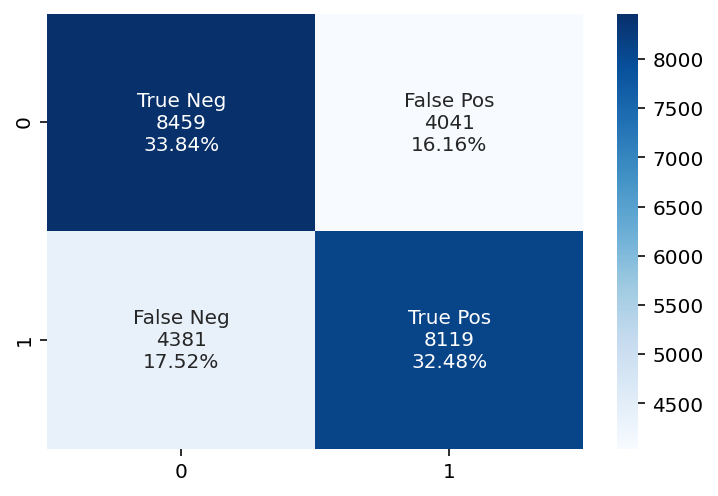

In [68]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')